## Spotify Billboard 200 Exploratory Analysis

Here we perform an exploratory analysis of the involved features, and discuss possible issues.

In [123]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

Let's start with `acoustic_features.csv`, which contains the panel data for our regression problem, and preview the data

In [77]:
af_raw = pd.read_csv("./data/acoustic_features.csv")
af_raw.head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
0,0Veyvc3n9AcLSoK3r1dA12,Voices In My Head,Hoodie SZN,A Boogie Wit da Hoodie,0.0555,0.754,142301.0,0.663,0.000000,6.0,0.101,-6.311,0.0,0.427,90.195,4.0,0.207,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
1,77JzXZonNumWsuXKy9vr3U,Beasty,Hoodie SZN,A Boogie Wit da Hoodie,0.2920,0.860,152829.0,0.418,0.000000,7.0,0.106,-9.061,0.0,0.158,126.023,4.0,0.374,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
2,18yllZD0TdF7ykcREib8Z1,I Did It,Hoodie SZN,A Boogie Wit da Hoodie,0.1530,0.718,215305.0,0.454,0.000046,8.0,0.116,-9.012,1.0,0.127,89.483,4.0,0.196,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
3,1wJRveJZLSb1rjhnUHQiv6,Swervin (feat. 6ix9ine),Hoodie SZN,A Boogie Wit da Hoodie,0.0153,0.581,189487.0,0.662,0.000000,9.0,0.111,-5.239,1.0,0.303,93.023,4.0,0.434,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
4,0jAfdqv18goRTUxm3ilRjb,Startender (feat. Offset and Tyga),Hoodie SZN,A Boogie Wit da Hoodie,0.0235,0.736,192779.0,0.622,0.000000,6.0,0.151,-4.653,0.0,0.133,191.971,4.0,0.506,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21


Let's check out our list of features and the shape of the data, checking for missing data. Recall that we wish to predict `danceability` from the other columns, so all the other columns except for `danceability` are our *features*, while `danceability` is our *response* variable.

In [78]:
X = af_raw.loc[:, af_raw.columns != "danceability"]
y = af_raw["danceability"]
n_features = len(X.columns)
af_raw_shape = af_raw.shape
af_dropna_shape = af_raw.dropna().shape
print("number of features: {0}\nraw shape: {1}\nwithout NA: {2}\ndifference: {3}"
      "".format(n_features, af_raw_shape, af_dropna_shape, af_raw_shape[0] - af_dropna_shape[0]))

number of features: 18
raw shape: (339855, 19)
without NA: (339799, 19)
difference: 56


Ugh, we have missing values. Let's quickly tally how many of the missing values are in each column.

In [79]:
# counts of missing values as a dictionary
mv_counts = {af_raw.columns[i]: 0 for _ in range(n_features + 1)}
# isna() and then sum boolean values (true is 1, false is 0)
for i in range(n_features + 1): mv_counts[af_raw.columns[i]] = sum(af_raw[af_raw.columns[i]].isna())
print("{0}".format(mv_counts))

{'date': 0, 'id': 0, 'song': 0, 'album': 0, 'artist': 51, 'acousticness': 5, 'danceability': 5, 'duration_ms': 5, 'energy': 5, 'instrumentalness': 5, 'key': 5, 'liveness': 5, 'loudness': 5, 'mode': 5, 'speechiness': 5, 'tempo': 5, 'time_signature': 5, 'valence': 5, 'album_id': 0}


The majority of the entries with NA values are missing `artist` values. However, for the other missing features, there are exactly 5 missing entries for each. This may be due to recording errors, and we may only have 5 defective rows. We therefore look for rows that are missing just `valence` (could be another one of the features), because if our hypothesis is right, these 5 rows will contain all the other missing features as well.

In [80]:
missing = af_raw.loc[af_raw["valence"].isna(), ]
missing

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
59124,0CTPQF9t7VhbeaadIaXUj4,"Brave Sword, Braver Soul",Rio 2: Music From The Motion Picture,Soundtrack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2UHsd8xIIfzb45usr3n5Sq,2019-03-26
94340,3PfWcsnd0v5JguxWTMzE3F,Group Therapy Intro (ABGT325),Group Therapy,Above & Beyond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5pZqJmRtWYIMRuis7usYMX,2019-04-07
183287,60mTlAJswlhbROAcsaxfsA,"Nocturnes, Op. 9: No. 1, Larghetto in B-Flat M...",Classical Hits,Various Artists,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4ZMu2yKyH4UEqWkmoXz60m,2019-03-30
191991,6XFqSSPw9K6EdZO54QghgG,Split Yo Face,EBK4,Brotha Lynch Hung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57CNgCqpHitXOALuazgeFs,1999-07-13
240050,7Ejk29jo1lKAAQI7UuooAq,We're Gonna Kick It Once,Three The Hard Way,Rodney O & Joe Cooley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4ongwa5RCHuq55GbOmw4WJ,1990-02-22


Clearly, the other 51 rows have all their fields except for the artist field. Let's see why.

In [99]:
no_artist = af_raw.loc[af_raw["artist"].isna(), ]
no_artist.head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
334300,0ZUFk0afed2FkqmuJ5zGxR,Shootin' Creek (with The North Carolina Ramblers),Roots Of Country Music (1965),NaN,0.953,0.712,204307.0,0.514,0.004250,5.0,0.0813,-10.511,1.0,0.0391,133.558,4.0,0.923,0jckzrST0anXNTY13KMbSw,2005
334301,5Xhj8u4dAeZYaZwXQJsQ4E,Baltimore Fire (with The North Carolina Ramblers),Roots Of Country Music (1965),NaN,0.901,0.512,191800.0,0.439,0.000001,7.0,0.2220,-8.519,1.0,0.0311,115.861,4.0,0.935,0jckzrST0anXNTY13KMbSw,2005
334302,2bKkPsqxC7o4V2lcwbI18U,Leaving Home (with The North Carolina Ramblers),Roots Of Country Music (1965),NaN,0.988,0.420,189253.0,0.431,0.000314,0.0,0.0653,-10.915,1.0,0.0406,205.555,3.0,0.901,0jckzrST0anXNTY13KMbSw,2005
334303,1hPEhm8zQk4hAyYeD1pHUc,There'll Come a Time (with The North Carolina ...,Roots Of Country Music (1965),NaN,0.961,0.445,209027.0,0.332,0.000000,5.0,0.1340,-11.053,1.0,0.0336,182.993,3.0,0.831,0jckzrST0anXNTY13KMbSw,2005
334304,3UG5yKkePf93z9RSBsbPE5,White House Blues (with The North Carolina Ram...,Roots Of Country Music (1965),NaN,0.919,0.546,208813.0,0.409,0.000006,7.0,0.2920,-8.769,1.0,0.0477,121.444,4.0,0.815,0jckzrST0anXNTY13KMbSw,2005


If one increases the number of rows to show, it seems that the majority of the albums with the missing artist are collections of songs by various artists. Thus, we could replace the NaN in this column with "Various Artists" instead. According to results from a Google Search, the song "Silhouette", from the album *Silhouette*, may be by Kenny G. Since this is only one observation, we can just fill the missing value in and carry on.

In [113]:
af_raw.iloc[241999, 3] = "Kenny G"
af_raw.loc[pd.isna(af_raw["artist"]), af_raw.columns == "artist"] = "Various Artists"
af_raw.loc[af_raw["artist"] == "Various Artists", ].head()

,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
3585,4ylWMuGbMXNDgDd8lErEle,The Greatest Show,The Greatest Showman: Reimagined,Various Artists,0.000239,0.417,302147.0,0.824,0.054500,11.0,0.0725,-7.360,0.0,0.1050,157.920,4.0,0.4000,7ayBZIe1FHkNv0T5xFCX6F,2017-12-08
3586,0RoA7ObU6phWpqhlC9zH4Z,A Million Dreams,The Greatest Showman: Reimagined,Various Artists,0.243000,0.265,269453.0,0.312,0.000000,7.0,0.0893,-11.689,1.0,0.0569,54.747,3.0,0.0998,7ayBZIe1FHkNv0T5xFCX6F,2017-12-08
3587,66y7x28jXOPrcmu3D5Zjh6,A Million Dreams (Reprise),The Greatest Showman: Reimagined,Various Artists,0.726000,0.253,60453.0,0.139,0.000050,6.0,0.2690,-17.067,1.0,0.0414,74.369,3.0,0.1020,7ayBZIe1FHkNv0T5xFCX6F,2017-12-08
3588,5xNUR50KxswPRAvx7S163g,Come Alive,The Greatest Showman: Reimagined,Various Artists,0.005580,0.702,225933.0,0.770,0.000802,7.0,0.2110,-9.411,1.0,0.1280,118.034,4.0,0.2350,7ayBZIe1FHkNv0T5xFCX6F,2017-12-08
3589,2cKovq3l6OJjhVVDbVKOsr,The Other Side,The Greatest Showman: Reimagined,Various Artists,0.004330,0.638,214373.0,0.795,0.001390,0.0,0.1530,-8.450,1.0,0.3020,153.990,4.0,0.3100,7ayBZIe1FHkNv0T5xFCX6F,2017-12-08


We check the shape of the DataFrame again, and we are done filling in the missing values that matter. We can discard the 5 entries with no data.

In [117]:
af_dropna_shape = af_raw.dropna().shape
print("number of features: {0}\nraw shape: {1}\nwithout NA: {2}\ndifference: {3}"
      "".format(n_features, af_raw_shape, af_dropna_shape, af_raw_shape[0] - af_dropna_shape[0]))
# amend X and y
X = af_raw.loc[:, af_raw.columns != "danceability"].dropna().copy()
y = af_raw["danceability"].dropna().copy()
print("X shape: {0}\ty shape: {1}".format(X.shape, y.shape))

number of features: 18
raw shape: (339855, 19)
without NA: (339850, 19)
difference: 5
X shape: (339850, 18)	y shape: (339850,)


Now that we have finished handling our missing data, we can get to the actual exploratory feature analysis.

From the Spotify API documentation for getting audio features from a track [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/), we already have some of our initial exploratory analysis. Refer to the link for descriptions of all the features; we are lucky in that many of the features are calculated values that have well defined ranges. For example, `danceability` itself in on $ [0, \, 1] $, and so are the features `acousticness`, `energy`, `instrumentalness`, `liveness`, `speechiness`, and `valence`.


From the pictures below, we can already see that generally popular songs are **not** acoustic in nature, i.e. most values in `acousticness` are close to 0, although there is variation. `danceability` itself seems to be negatively skewed but with a mean above 0.5, while `energy` is denser on the upper end of the $ [0, \, 1] $ interval. `instrumentalness` markedly shows that the vast majority of popular Billboard 200 songs are not instrumental. Most of the tracks are not performed live; i.e. `liveness` is clustered in the low end with a long upward tail. Also, the vast majority of tracks are **not** speechy; i.e. `speechiness` is typically low and so most songs are musical. Interestingly, `valence` is more or less symmetric, forming a hump distribution; we see that more songs inbetween "happy" or "sad" are popular, but so are many "happy" or "sad" songs.

We can perform some analysis on the non-standardized features now, which include `key`, `mode`, `time_signature`, `loudness`, `tempo`, `duration_ms`, and `date`. `date` we will treat specially, so we put that aside for now. We make some histograms below for the continuous features `loudness`, `duration_ms`, and `tempo`. `key` is categorical [pitch class](https://en.wikipedia.org/wiki/Pitch_class), `mode` is binary 0 (minor), 1 (major), and `time_signature` indicates beats in a bar.

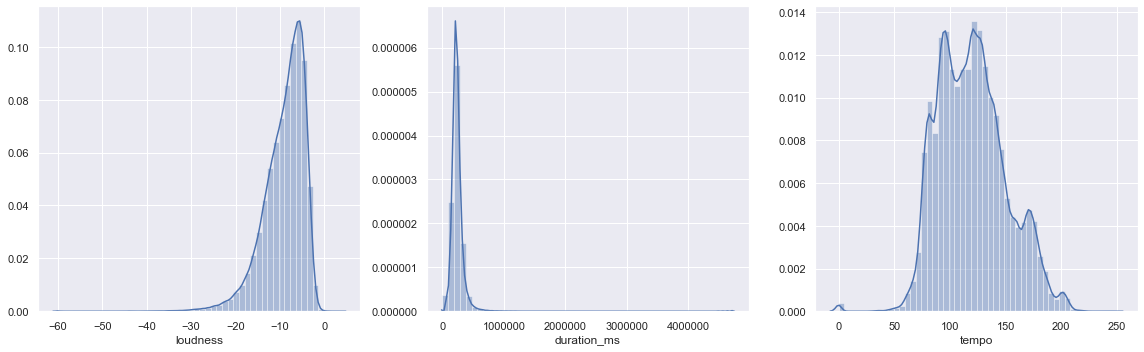

In [126]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
cols = ["loudness", "duration_ms", "tempo"]
for col, ax in zip(cols, axs): sns.distplot(X[col], kde = True, ax = ax)
# prevent graphs from being squished
fig.tight_layout()

We can also calculate some statistics for these features to get a better sense of what they are like beyond visual inspection.

In [124]:
for col in cols:
    print("{0}: {1}".format(col, {"mean": X[col].mean(), "std": X[col].std(), "skew": sps.skew(X[col])}))

loudness: {'mean': -9.07275937619538, 'std': 4.601031677300458, 'skew': -1.4151758598479278}
duration_ms: {'mean': 236735.11662203915, 'std': 102255.71349454521, 'skew': 6.483528429896756}
tempo: {'mean': 119.9339735530381, 'std': 30.380898639898025, 'skew': 0.3284185006641375}


Note that `skew < 0` indicates a heavier left tail, while `skew > 0` indicates a heavier right tail. We now proceed to create bar charts using `countplot` for categorical features `key`, `mode`, and `time_signature`, which we have below.

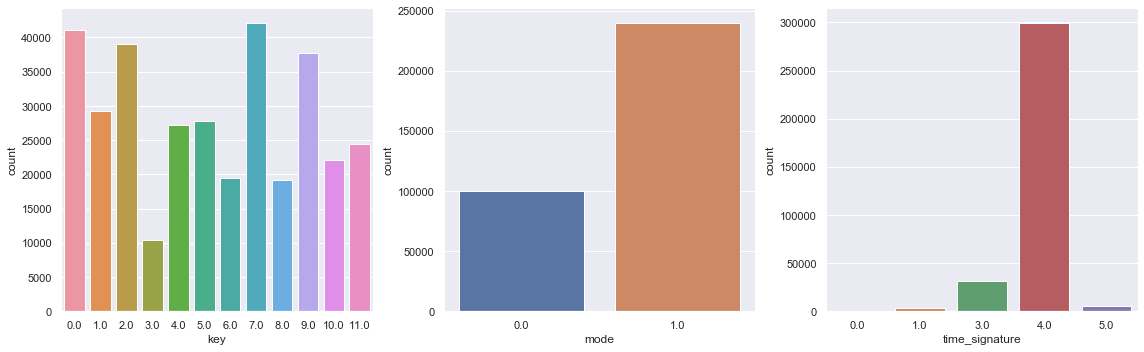

In [127]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
cols = ["key", "mode", "time_signature"]
for col, ax in zip(cols, axs): sns.countplot(X[col], ax = ax)
fig.tight_layout()

One can see that the keys are mixed in distribution. From looking at the pitch classes [here](https://en.wikipedia.org/wiki/Pitch_class), we see that there are higher frequencies of songs in the C (0), D (2), G (7), and A (9) keys. In general, as expected, more songs are of the major key, as in seen from the graph of `mode`. Also as expected, `time_signature` is mostly 4 beats per measure, with some 3 beats per measure. However, there appear to be instances where there are 0 beats per measure. Let's see:

In [136]:
zero_beats = X.loc[X["time_signature"] == 0, ]
zero_beats.head()

,id,song,album,artist,acousticness,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
114,7A5uLkZbEOzHiAlhD2Hr2L,"First Stop, Arizona - Dialogue",A Star Is Born (Soundtrack),Lady Gaga & Bradley Cooper,0.878,10760.0,0.2300,0.0000,6.0,0.194,-23.413,1.0,0.0,0.0,0.0,0.0,4sLtOBOzn4s3GDUv3c5oJD,2018-10-05
120,1UR9zquKVw87PBAl5b9PDH,How Do You Hear It? - Dialogue,A Star Is Born (Soundtrack),Lady Gaga & Bradley Cooper,0.606,14507.0,0.1300,0.0000,9.0,0.355,-21.347,1.0,0.0,0.0,0.0,0.0,4sLtOBOzn4s3GDUv3c5oJD,2018-10-05
127,2YEslbHiO4TyqNv2BQ2EWJ,SNL - Dialogue,A Star Is Born (Soundtrack),Lady Gaga & Bradley Cooper,0.408,13147.0,0.0604,0.0000,6.0,0.509,-20.782,1.0,0.0,0.0,0.0,0.0,4sLtOBOzn4s3GDUv3c5oJD,2018-10-05
508,439gEXy3QO4CwMA2Fd8yDS,Emotion,Ella Mai,Ella Mai,0.565,11969.0,0.2580,0.0000,3.0,0.109,-11.957,0.0,0.0,0.0,0.0,0.0,67ErXRS9s9pVG8JmFbrdJ0,2018-10-12
3370,2fiedSmEBdaJcqiOO9DoBG,Michael's Christmas Greeting (Hidden Track) - ...,Christmas,Michael Buble,0.630,3947.0,0.0340,0.0149,1.0,0.000,-20.736,0.0,0.0,0.0,0.0,0.0,7uVimUILdzSZG4KKKWToq0,2012-11-09


I think it is pretty clear these songs have more than zero beats per measure. We check that there are 18 entries with 0 beats per measure.

In [137]:
zero_beats.shape

(649, 18)